In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [18]:
diamonds_df = pd.read_csv('diamonds.csv')

In [19]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


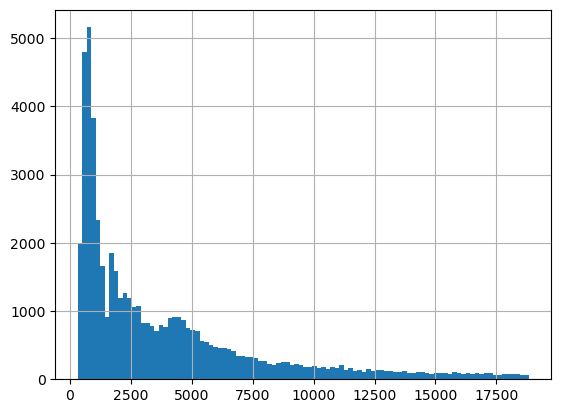

In [20]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [21]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [22]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [23]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [24]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [25]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [27]:
reg = LinearRegression().fit(X_train, y_train)

In [28]:
y_pred = reg.predict(X_test)

In [29]:
score = r2_score(y_pred, y_test)

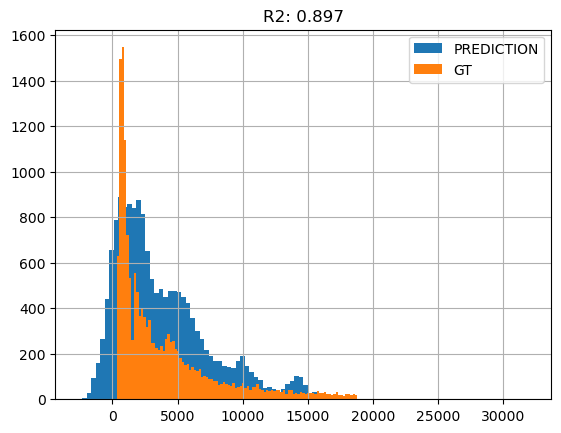

In [30]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [150]:
class MyMLPRegressor:
    def __init__(self, num_inputs, num_outputs, hidden_layers=(100,), learningrate=0.001, maxiter=10):
        self.learningrate= learningrate
        self.hidden_layers = hidden_layers
        self.maxiter = maxiter

        layers = [num_inputs] + [hidden_layers[0]] + [num_outputs]

        weights = []
        for i in range(len(layers) - 1):
            w = np.random.rand(layers[i], layers[i + 1])
            weights.append(w)
        self.weights = weights

        derivatives = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i], layers[i + 1]))
            derivatives.append(d)
        self.derivatives = derivatives

        activations = []
        for i in range(len(layers)):
            a = np.zeros(layers[i])
            activations.append(a)
        self.activations = activations

    def sigmoid(self, x):
        res = 1.0 / (1 + np.exp(-x))
        return res

    def dsigmoid(self, x):
        return x * (1.0 - x)

    def forwardpass(self, X):
        activations = X
        self.activations[0] = activations
        for i, w in enumerate(self.weights):
            net_inputs = np.dot(activations, w)
            activations = self.sigmoid(net_inputs)
            self.activations[i + 1] = activations
        return activations

    def backwardpass(self, error):
        for i in reversed(range(len(self.derivatives))):
            activations = self.activations[i+1]
            delta = error * self.dsigmoid(activations)
            delta_re = delta.reshape(delta.shape[0], -1).T
            current_activations = self.activations[i]
            current_activations = current_activations.reshape(current_activations.shape[0],-1)

            self.derivatives[i] = np.dot(current_activations, delta_re)

            error = np.dot(delta, self.weights[i].T)


    def train(self, X, y):
        for i in range(self.maxiter):
            sum_errors = 0

            for j, input in enumerate(X):
                target = y[j]

                output = self.forwardpass(input)
                error = target - output
                # print("BEFORE",self.derivatives)
                self.backwardpass(error)
                # print("AFTER",self.derivatives)

                self.gradient_descent(self.learningrate)

                sum_errors += self.mse(target, output)
            print("Error: {} at epoch {}".format(sum_errors / len(X), i+1))

    def gradient_descent(self, learningRate):
        for i in range(len(self.weights)):
            self.weights[i] += self.derivatives[i] * learningRate

    def mse(self, target, output):
        return np.average((target - output) ** 2)

    def predict(self, X):
        activations = self.forwardpass(X)
        return activations

# Проверяем модель MLP на выборке Diamonds

In [151]:

from skimage.metrics import mean_squared_error
mlp = MyMLPRegressor(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_layers=(20,),maxiter=10)

mlp.train(X_train,y_train)


y_pred = mlp.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

Error: 31519644.232714143 at epoch 1
Error: 31519644.207213517 at epoch 2
Error: 31519644.206101403 at epoch 3
Error: 31519644.205646843 at epoch 4
Error: 31519644.20539757 at epoch 5
Error: 31519644.205240354 at epoch 6
Error: 31519644.205131274 at epoch 7
Error: 31519644.205051616 at epoch 8
Error: 31519644.204991113 at epoch 9
Error: 31519644.20494304 at epoch 10
Mean squared error: 31035441.575836264


In [100]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=10).fit(X_train, y_train)
y_pred1=regr.predict(X_test)
print(y_pred1)


print(y_test.reshape(16182,))
mse = mean_squared_error(y_test.reshape(16182,), y_pred1)
print("Mean squared error:", mse)

C:\Users\denok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1587.8221626  1955.72542032 1292.34039353 ... 1790.2800687  2049.86199007
 1639.82439843]
[1240  515  614 ...  422 4142 1033]
Mean squared error: 20044213.57117038


C:\Users\denok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
